In [18]:
import gensim #pip install gensim
import pprint
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models
import time

''' 
 default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS
'''

" \n default_term_info = default_term_info.sort_values(\n        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS\n"

In [19]:
#1. Creazione del TF-IDF (Term Frequency - Inverse Document Frequency), assegnamo un peso ad ogni parola
#  - TF: frequenza del termine nel documento: num. occorrenze / num. totale di parole nel documento
#  - IDF: inverso della frequenza del termine nei documenti: log(num. totale di documenti / num. documenti che contengono il termine)
#  - TF-IDF: prodotto delle due precedenti (risulta elevato quando la parola è molto presente nel documento e poco presente negli altri documenti)

source = './doc/cleaned.csv'
df = pd.read_csv(source)

#Tokenizzazione
tweets = df['lemmatized_text'].apply(lambda text: word_tokenize(text))

# Create a dictionary
dictionary = corpora.Dictionary(tweets)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in tweets]

# Train the TF-IDF model
tfidf = models.TfidfModel(corpus)

# Transform the corpus into TF-IDF vectors
tfidf_corpus = tfidf[corpus]

In [20]:
# Show some results
for i, doc in enumerate(tfidf_corpus):
    if i > 1:
        break
    print(f"TF-IDF values for document {i}:")
    for token_id, tfidf_value in doc:
        word = dictionary[token_id]  # Get the word corresponding to the token_id
        print(f"Token ID: {token_id}, Word: {word}, TF-IDF Value: {tfidf_value}")
    print("\n")

TF-IDF values for document 0:
Token ID: 0, Word: allegedly, TF-IDF Value: 0.12172989758275168
Token ID: 1, Word: atomic, TF-IDF Value: 0.1634823533125282
Token ID: 2, Word: ban, TF-IDF Value: 0.08655558351002021
Token ID: 3, Word: beijing, TF-IDF Value: 0.13310445728329873
Token ID: 4, Word: bloomberg, TF-IDF Value: 0.1542898494173349
Token ID: 5, Word: briefcase, TF-IDF Value: 0.20824116373793852
Token ID: 6, Word: carrying, TF-IDF Value: 0.13378329113794132
Token ID: 7, Word: chemical, TF-IDF Value: 0.13061197716703943
Token ID: 8, Word: come, TF-IDF Value: 0.0725474152860395
Token ID: 9, Word: conducted, TF-IDF Value: 0.14241856339194872
Token ID: 10, Word: decade, TF-IDF Value: 0.09111724804433256
Token ID: 11, Word: established, TF-IDF Value: 0.1384742945275382
Token ID: 12, Word: explosion, TF-IDF Value: 0.14414279212329145
Token ID: 13, Word: filmed, TF-IDF Value: 0.169426570452489
Token ID: 14, Word: hour, TF-IDF Value: 0.09567315404986595
Token ID: 15, Word: model, TF-IDF Valu

In [21]:
def execute_LDA(n_topic, corpus, dictionary, epochs, multicore = True):
    start_time = time.time()
    
    logging.basicConfig(level=logging.WARNING)
    
    if multicore:
        #execute
        lda_model = LdaMulticore(
            corpus = corpus, #corpus in tfidf
            id2word = dictionary, #dizionario (vocabolario dei miei documenti)
            num_topics = n_topic,
            random_state = 42, #per riproducibilità
            passes = epochs,
            per_word_topics = True,
            workers = 3
            )
    else:
        print('lda normale')
        lda_model = LdaModel(
        corpus = corpus, #corpus in tfidf
        id2word = dictionary, #dizionario (vocabolario dei miei documenti)
        alpha = 'auto',
        eta = 'auto',
        num_topics = n_topic,
        random_state = 42, #per riproducibilità
        passes = epochs,
        per_word_topics = True) 
    
    #save model
    lda_model.save(f'models/lda_model_{n_topic}_{epochs}')
    
    
    # Compute Coherence Score u_mass
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
    coherence_umass = coherence_model_lda.get_coherence()
    
    # Compute Coherence Score c_v
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_lda_cv.get_coherence()
    
    end_time = time.time()
    
    return lda_model, coherence_umass, coherence_cv, end_time - start_time

def print_topic(num, lda_model):
    topics = lda_model.show_topics(num_topics=num, num_words=10)  # You can adjust the number of words as needed
    print("\n----- TOPIC -----")
    i = 0
    for topic in topics:
        i = i + 1
        topic_words = topic[1].split("+")
        words = [word.split("*")[1].strip() for word in topic_words]
        topic_str = ', '.join(words)
        print(f"Topic{i}: {topic_str}")
    #lda_model.show_topics(formatted=False)
    

In [8]:
#Execute LDA
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

trial = [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for i in trial:
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)
    



Executing LDA with 8 topics and 100 epochs


Execution time: 13.006 min
Coherence umass: -9.200 e Coherence cv: 0.536

----- TOPIC -----
Topic1: "border", "menendez", "illegal", "migrant", "dakota", "wall", "southern", "bob", "immigrant", "mccarthy"
Topic2: "day", "today", "great", "join", "thank", "happy", "tune", "tonight", "live", "honor"
Topic3: "taylor", "music", "copy", "hypocrisy", "suck", "livestream", "author", "score", "rubio", "embarrassing"
Topic4: "newsom", "editor", "gavin", "faa", "letter", "productive", "politico", "analysis", "overturned", "fulton"
Topic5: "biden", "trump", "people", "amp", "joe", "president", "ukraine", "house", "government", "american"
Topic6: "gun", "violence", "shooting", "weapon", "assault", "pact", "michigander", "fentanyl", "writes", "toxic"
Topic7: "trump", "vote", "election", "republican", "gop", "debate", "candidate", "poll", "democrat", "voter"
Topic8: "american", "job", "act", "care", "year", "family", "amp", "working", "health", "work"


Executing LDA with 11 topics and 100 epochs
Ex

N.Topics: [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Coherence score: [-9.200441042234985, -7.178833185929441, -7.934364339070924, -9.295775880818848, -7.895624630072998, -9.895410012650816, -10.061093923152749, -8.384642388693546, -9.081364282865856, -8.790754822324054, -10.354005081963097]


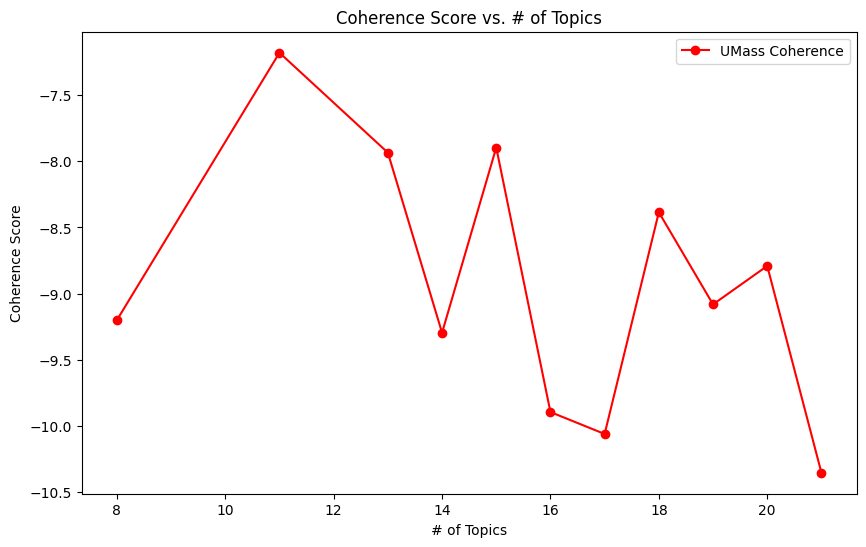

In [14]:

# Load the saved LDA model
#lda_model_up = LdaModel.load("lda_model")

print("N.Topics:", n_topics)
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(n_topics, coherence_umass, marker='o', color='red', label='UMass Coherence')
#plt.plot(n_topics, coherence_cv, marker='*', color = 'blue', label = 'CV Coherence')
plt.legend(loc='best')
plt.title('Coherence Score vs. # of Topics')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [22]:
#pyLDAvis (https://siqi-zhu.medium.com/ldavis-a-deep-dive-into-the-popular-topic-modeling-tool-d0c61a03e969)
pyLDAvis.enable_notebook()
model = LdaModel.load("models/lda_model_15_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_15_100.html') #da fare dopo la visualizzazione altrimenti non lo mostra

In [23]:
model = LdaModel.load("models/lda_model_11_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [24]:
#Addestramento ulteriore per 11 topic
coherence_umass = []
coherence_cv = []
epochs = [150, 200, 250, 300, 350, 400, 500, 600]

for e in epochs:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)
    




Executing LDA with 11 topics and 150 epochs
Execution time: 16.419 min
Coherence umass: -8.444 e Coherence cv: 0.584

----- TOPIC -----
Topic1: "tuberville", "spring", "rsvp", "pact", "exposed", "schumer", "eligible", "yorkers", "till", "contact"
Topic2: "day", "today", "thank", "woman", "great", "happy", "year", "work", "community", "country"
Topic3: "larry", "elder", "adviser", "upgrade", "joy", "anybody", "suck", "profile", "trading", "surrender"
Topic4: "menendez", "newsom", "bob", "pet", "resign", "mcconnell", "mitch", "gavin", "dobbs", "shame"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "democrat", "know", "think"
Topic6: "texas", "poll", "gun", "laura", "ingraham", "angle", "virginian", "lean", "weapon", "rating"
Topic7: "tune", "tonight", "live", "join", "watch", "listen", "hall", "town", "debate", "joining"
Topic8: "american", "job", "act", "amp", "care", "working", "family", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election", "repub

In [31]:
#Addestramento ulteriore per 11 topic
'''
for e in [350, 400, 500, 600]:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)
    '''




Executing LDA with 11 topics and 350 epochs
Execution time: 43.854 min
Coherence umass: -8.373 e Coherence cv: 0.573

----- TOPIC -----
Topic1: "tuberville", "rsvp", "spring", "exposed", "schumer", "till", "highway", "rebuilding", "yorkers", "contact"
Topic2: "day", "today", "thank", "great", "happy", "woman", "year", "work", "community", "family"
Topic3: "larry", "elder", "lowest", "transit", "trading", "upgrade", "suck", "joy", "anybody", "percent"
Topic4: "menendez", "resign", "newsom", "bob", "ramaswamy", "vivek", "gavin", "mcconnell", "mitch", "pet"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "know", "democrat", "think"
Topic6: "texas", "gun", "poll", "virginian", "lean", "rating", "writes", "prevention", "toss", "weapon"
Topic7: "tune", "tonight", "live", "join", "listen", "hall", "watch", "town", "joining", "tomorrow"
Topic8: "american", "job", "act", "amp", "working", "family", "care", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election

[-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747] [150, 200, 250, 300, 350, 400, 500, 600]
11 topic
Coherence score: [-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747]


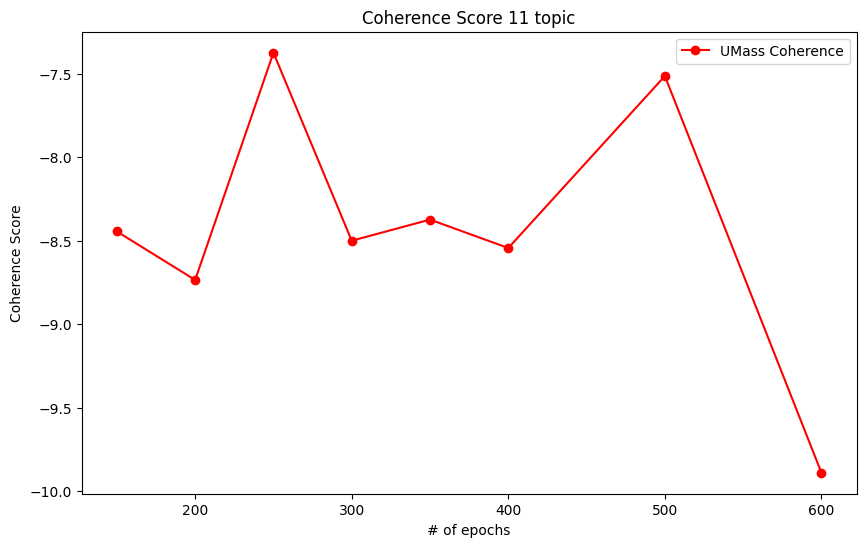

In [36]:
#Mostro i risultati per l'ulteriore addestramento
epochs = [150,200, 250, 300, 350, 400, 500, 600]
print(coherence_umass, epochs)
print("11 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 11 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()

In [ ]:
model = LdaModel.load("models/lda_model_11_250")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [4]:
model = LdaModel.load("models/lda_model_11_600")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [38]:
#Addestramento ulteriore per 15 topic
epochs = [150,200, 250, 300, 350, 400, 500, 600]
for e in epochs:
    print(f"\n\nExecuting LDA with 15 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(15, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(15, model)



Executing LDA with 15 topics and 150 epochs
Execution time: 17.419 min
Coherence umass: -9.534 e Coherence cv: 0.597

----- TOPIC -----
Topic1: "trump", "debate", "gop", "candidate", "election", "republican", "presidential", "desantis", "primary", "vote"
Topic2: "today", "great", "day", "thank", "join", "happy", "community", "amp", "year", "state"
Topic3: "honor", "woman", "freedom", "sacrifice", "day", "american", "nation", "country", "history", "god"
Topic4: "drug", "cost", "prescription", "insulin", "senior", "medicare", "price", "lower", "reduction", "insurance"
Topic5: "hamas", "israel", "iran", "toss", "shit", "editor", "manchin", "letter", "palestinian", "gaza"
Topic6: "worker", "union", "strike", "auto", "uaw", "poverty", "contract", "solidarity", "expanded", "picket"
Topic7: "flight", "snap", "cancellation", "faa", "pilot", "cancel", "retweet", "rent", "airline", "holiday"
Topic8: "american", "job", "working", "family", "amp", "year", "economy", "act", "care", "million"
Topi

[-9.534322994976044, -8.993258058710204, -8.81224050083686, -9.426408956746998, -9.426673490372126, -10.564319215388155, -9.81472293289333, -9.546883965975578] [150, 200, 250, 300, 350, 400, 500, 600]
15 topic
Coherence score: [-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747, -9.534322994976044, -8.993258058710204, -8.81224050083686, -9.426408956746998, -9.426673490372126, -10.564319215388155, -9.81472293289333, -9.546883965975578]


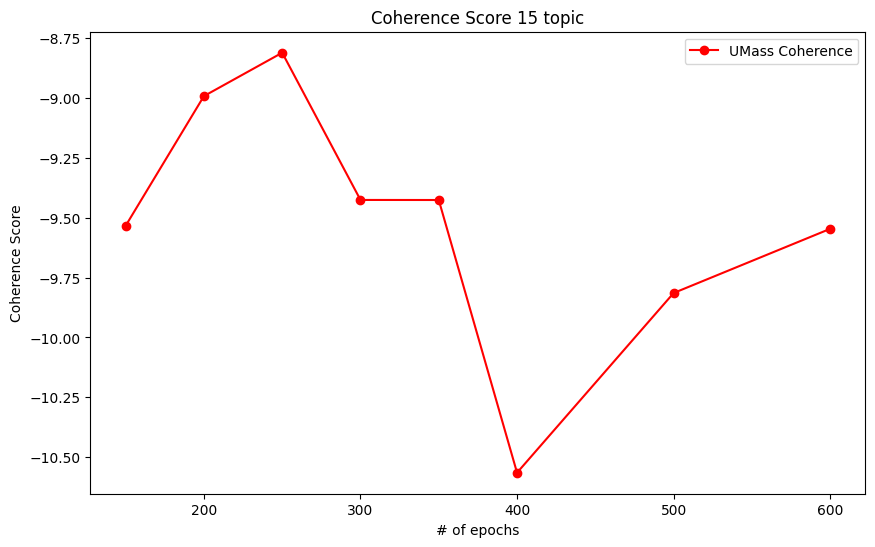

In [41]:
#Mostro i risultati per l'ulteriore addestramento
print(coherence_umass[8:16], epochs)
print("15 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_umass[8:16], marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 15 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()

In [48]:
model = LdaModel.load("models/lda_model_15_250")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_15_250.html')

In [7]:
#Execute LDA
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

#Provo ad addestrare con un numero minore di topic
trial = [7,8,9,10, 12]
for i in trial:
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)



Executing LDA with 7 topics and 100 epochs


Execution time: 17.274 min
Coherence umass: -5.201 e Coherence cv: 0.553

----- TOPIC -----
Topic1: "biden", "border", "joe", "hunter", "house", "illegal", "crisis", "impeachment", "president", "mccarthy"
Topic2: "day", "today", "great", "thank", "join", "happy", "tune", "year", "honor", "tonight"
Topic3: "menendez", "laura", "bob", "ingraham", "angle", "resign", "senator", "older", "african", "tonight"
Topic4: "abortion", "woman", "right", "court", "freedom", "reproductive", "decision", "supreme", "ban", "larry"
Topic5: "ukraine", "war", "biden", "trump", "amp", "china", "military", "people", "israel", "state"
Topic6: "american", "job", "act", "working", "family", "worker", "amp", "work", "care", "year"
Topic7: "trump", "election", "vote", "republican", "debate", "candidate", "gop", "poll", "voter", "democrat"


Executing LDA with 8 topics and 100 epochs
Execution time: 11.794 min
Coherence umass: -7.737 e Coherence cv: 0.536

----- TOPIC -----
Topic1: "border", "biden", "speaker", "m

In [12]:
model = LdaModel.load("models/lda_model_7_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_7_100.html')

In [23]:
#Executing 7 topics with different epochs
coherence_7_umass = []
topic = 7
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 120]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(7, tfidf_corpus, dictionary, e)
    coherence_7_umass.append(umass)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 7 topics and 1 epochs


Execution time: 0.320 min
Coherence umass: -2.893 e Coherence cv: 0.508

----- TOPIC -----
Topic1: "job", "american", "biden", "care", "year", "family", "president", "working", "need", "million"
Topic2: "trump", "people", "biden", "american", "right", "party", "president", "america", "republican", "state"
Topic3: "biden", "republican", "trump", "elder", "american", "state", "year", "right", "people", "house"
Topic4: "trump", "biden", "president", "republican", "donald", "democrat", "gop", "time", "like", "debate"
Topic5: "biden", "american", "vote", "people", "today", "border", "law", "state", "house", "republican"
Topic6: "day", "election", "today", "state", "happy", "thank", "biden", "great", "student", "time"
Topic7: "american", "right", "biden", "woman", "today", "president", "year", "trump", "fight", "climate"


Executing LDA with 7 topics and 5 epochs
Execution time: 1.026 min
Coherence umass: -5.136 e Coherence cv: 0.557

----- TOPIC -----
Topic1: "american", "job", "working", "

[-2.892965800456395, -5.135764911693228, -5.697392022925255, -5.933761709583623, -5.781216430575065, -5.86324241498562, -5.8723413131867295, -5.868806736030466, -6.269335954191779, -5.947404544522486, -5.78631513946751, -5.964363233368454, -5.74044170309711] [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
Massimo valore ottenuto:  -2.892965800456395
7 topic
Coherence score: [-5.2013079808763445, -7.736869013453537, -9.574157608780794, -7.267087164449914, -9.109872493123861]


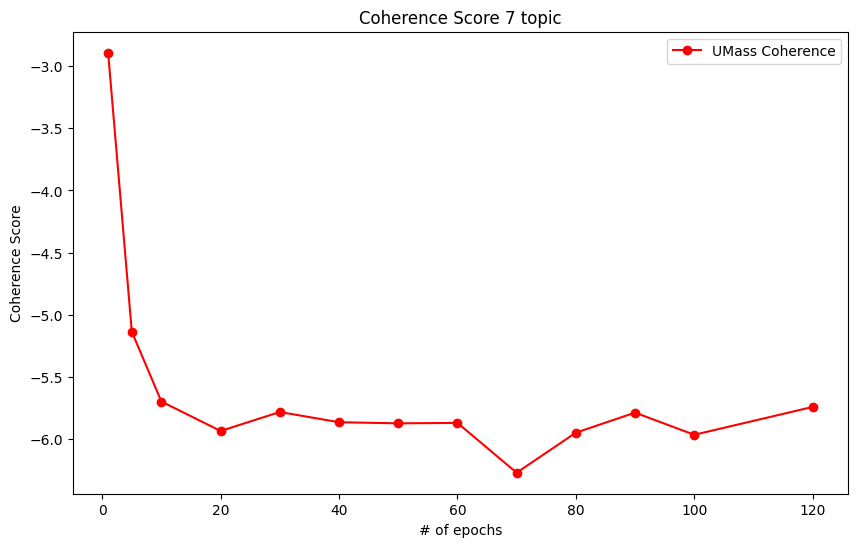

In [25]:
#Plot the coherence for the 7 topics
print(coherence_7_umass, epochs)
max_score = max(coherence_7_umass)
print("Massimo valore ottenuto: ", max_score)
print("7 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_7_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 7 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [26]:
#Executing 8 topics with different epochs
coherence_8_umass = []
coherence_8_cv = []
topic = 8
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_8_umass.append(umass)
    coherence_8_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 8 topics and 1 epochs
Execution time: 0.220 min
Coherence umass: -3.084 e Coherence cv: 0.494

----- TOPIC -----
Topic1: "care", "health", "job", "act", "american", "family", "biden", "year", "working", "republican"
Topic2: "trump", "people", "biden", "gun", "american", "republican", "party", "president", "time", "violence"
Topic3: "elder", "right", "biden", "trump", "court", "time", "voting", "people", "mccarthy", "american"
Topic4: "trump", "biden", "president", "donald", "republican", "election", "debate", "time", "people", "joe"
Topic5: "today", "border", "biden", "year", "day", "american", "happy", "state", "family", "people"
Topic6: "colorado", "election", "biden", "state", "trump", "day", "people", "vote", "president", "thank"
Topic7: "american", "woman", "president", "trump", "right", "biden", "people", "state", "today", "house"
Topic8: "american", "america", "biden", "year", "worker", "job", "family", "infrastructure", "president", "law"


Executing LDA wi

8 topic
Coherence score: [-3.0835910761166008, -4.654065951448132, -4.859301065526287, -5.161294170149704, -4.991111420748183, -4.894645024710876, -4.96853553548641, -5.279782132758272, -4.926276976599433, -4.977975137594242, -4.870220013801567, -4.9654678401137335, -5.35875671909673]
coherence cv:  [0.4939551816196816, 0.5439691091768071, 0.5586316125456219, 0.5602749671471333, 0.5776659224230293, 0.5731926042307702, 0.5861933098014779, 0.5801699656293717, 0.5820261019077786, 0.5777871108374146, 0.574786516601792, 0.5889963797301465, 0.566427724667778]
Massimo valore umass:  -3.0835910761166008
max valore cv:  0.5889963797301465


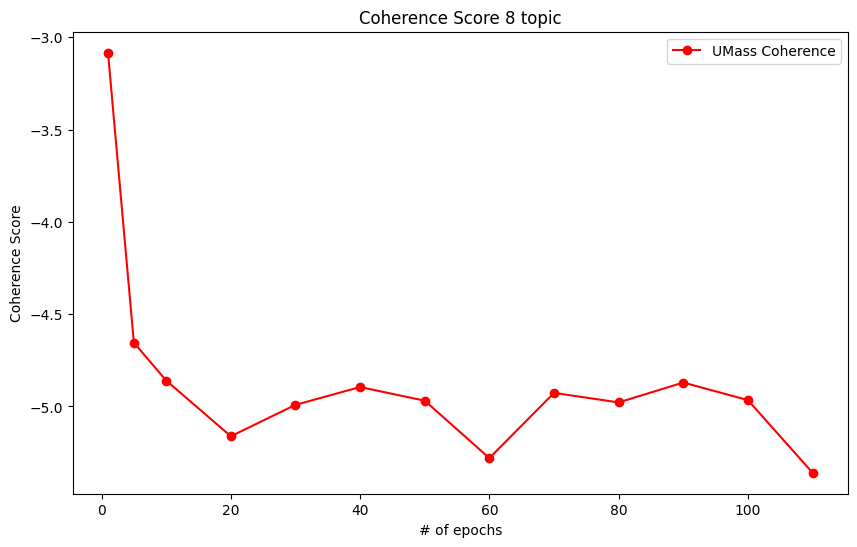

In [27]:
#Plot the coherence for the 8 topics

print("8 topic")
print("Coherence score:", coherence_8_umass)
print("coherence cv: ", coherence_8_cv)

print("Massimo valore umass: ", max(coherence_8_umass))
print("max valore cv: ", max(coherence_8_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_8_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 8 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [28]:
#Executing 9topics with different epochs
coherence_9_umass = []
coherence_9_cv = []
topic = 9
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_9_umass.append(umass)
    coherence_9_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 9 topics and 1 epochs
Execution time: 0.225 min
Coherence umass: -3.225 e Coherence cv: 0.492

----- TOPIC -----
Topic1: "biden", "border", "job", "gun", "american", "need", "president", "house", "year", "republican"
Topic2: "trump", "biden", "president", "republican", "people", "state", "house", "party", "time", "american"
Topic3: "elder", "cost", "american", "drug", "medicare", "senior", "biden", "larry", "republican", "insulin"
Topic4: "trump", "biden", "republican", "president", "democrat", "time", "want", "like", "need", "state"
Topic5: "american", "biden", "people", "state", "today", "right", "year", "worker", "day", "woman"
Topic6: "great", "american", "day", "biden", "today", "year", "school", "state", "child", "family"
Topic7: "american", "right", "today", "woman", "year", "president", "act", "work", "fight", "people"
Topic8: "veteran", "biden", "america", "infrastructure", "state", "year", "care", "benefit", "president", "american"
Topic9: "vote", "trump"

9 topic
Coherence score: [-3.225218943760299, -3.519209014034802, -4.1977669541785785, -4.035080906590508, -4.96761936003067, -5.160465339310133, -4.984377845969611, -5.5249887929530725, -4.499409276066938, -5.829307386372111, -6.286388054339093, -5.771997030468208, -6.049683537191993]
coherence cv:  [0.49204043720686463, 0.5697479856569794, 0.5601192110212679, 0.5634894174825948, 0.5608176014626637, 0.5554688944458719, 0.5613863857102457, 0.5559136834108128, 0.552869257542929, 0.5446054688297599, 0.5633305619050487, 0.5432131342252194, 0.5471206467166124]
Massimo valore umass:  -3.225218943760299
max valore cv:  0.5697479856569794


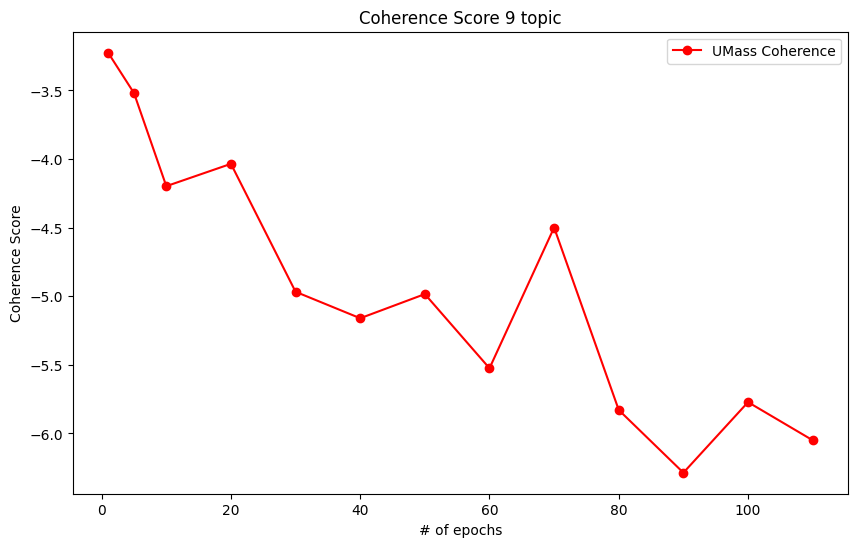

In [29]:
#Plot the coherence for the 8 topics

print("9 topic")
print("Coherence score:", coherence_9_umass)
print("coherence cv: ", coherence_9_cv)

print("Massimo valore umass: ", max(coherence_9_umass))
print("max valore cv: ", max(coherence_9_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_9_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 9 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [30]:
#Executing 10 topics with different epochs
coherence_10_umass = []
coherence_10_cv = []
topic = 10
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_10_umass.append(umass)
    coherence_10_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 10 topics and 1 epochs
Execution time: 0.229 min
Coherence umass: -3.166 e Coherence cv: 0.497

----- TOPIC -----
Topic1: "biden", "american", "great", "president", "week", "today", "community", "state", "need", "live"
Topic2: "biden", "trump", "writes", "republican", "democrat", "people", "american", "president", "house", "party"
Topic3: "trump", "biden", "right", "republican", "day", "court", "american", "people", "like", "state"
Topic4: "trump", "biden", "president", "donald", "republican", "election", "debate", "time", "joe", "party"
Topic5: "biden", "border", "day", "happy", "people", "today", "american", "state", "trump", "year"
Topic6: "elder", "biden", "community", "state", "election", "america", "today", "american", "like", "president"
Topic7: "american", "fight", "right", "work", "today", "woman", "year", "job", "people", "working"
Topic8: "american", "cost", "job", "act", "family", "care", "year", "republican", "tax", "million"
Topic9: "vote", "right", "

10 topic
Coherence score: [-3.166284859785047, -5.427913328074739, -6.732767783021416, -7.1599826865318565, -7.190588780827406, -7.160413276383072, -6.958485608743649, -7.169308580080451, -8.442866119719227, -7.28791111632066, -7.386194992982515, -7.3431926583927005, -7.077098473865499]
coherence cv:  [0.49696767003564846, 0.5280321007526466, 0.5478711695808526, 0.5553714694219185, 0.5453423413072327, 0.573082672344281, 0.5471322610700472, 0.5518329852347763, 0.5476795251939135, 0.5747586813655519, 0.5567748334594613, 0.5642868235943432, 0.5560133175839059]
Massimo valore umass:  -3.166284859785047
max valore cv:  0.5747586813655519


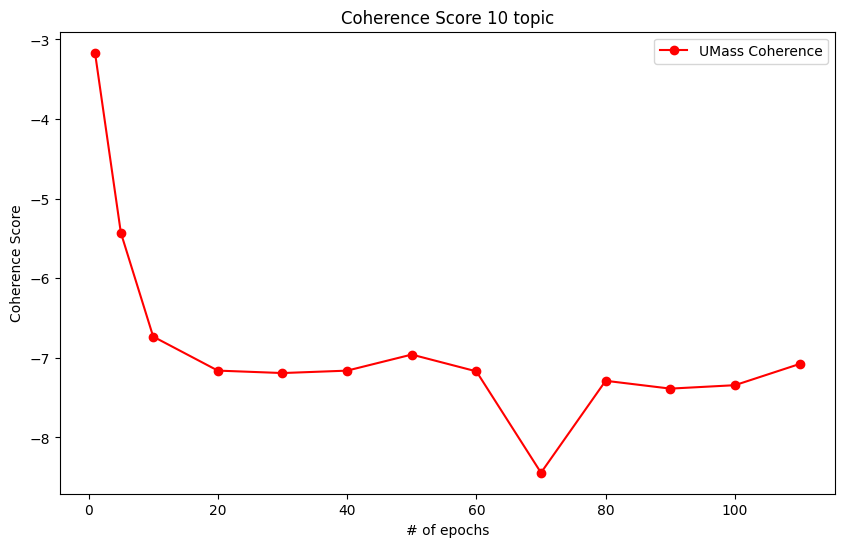

In [31]:
#Plot the coherence 
print("10 topic")
print("Coherence score:", coherence_10_umass)
print("coherence cv: ", coherence_10_cv)

print("Massimo valore umass: ", max(coherence_10_umass))
print("max valore cv: ", max(coherence_10_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_10_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 10 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [32]:
#Executing 11 topics with different epochs
coherence_11_umass = []
coherence_11_cv = []
topic = 11
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_11_umass.append(umass)
    coherence_11_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 11 topics and 1 epochs
Execution time: 0.216 min
Coherence umass: -3.365 e Coherence cv: 0.475

----- TOPIC -----
Topic1: "biden", "american", "family", "town", "join", "hall", "elder", "drug", "today", "need"
Topic2: "trump", "gun", "biden", "president", "people", "american", "israel", "need", "violence", "republican"
Topic3: "right", "biden", "mccarthy", "republican", "vote", "voting", "people", "american", "kevin", "trump"
Topic4: "trump", "biden", "republican", "president", "democrat", "donald", "jersey", "time", "american", "debt"
Topic5: "american", "biden", "year", "today", "cost", "insulin", "border", "state", "act", "people"
Topic6: "american", "job", "year", "president", "people", "state", "biden", "today", "family", "work"
Topic7: "job", "energy", "american", "infrastructure", "community", "act", "investment", "work", "climate", "year"
Topic8: "biden", "president", "trump", "america", "year", "time", "state", "american", "assault", "warren"
Topic9: "bide

11 topic
Coherence score: [-3.3651972695562886, -6.306272586604078, -6.917539915401787, -7.262947243513313, -7.17605987727408, -8.529982215188527, -7.461431172501269, -7.632681380542377, -8.076999477048668, -7.968371704385629, -8.388497780408214, -8.418197159196668, -8.634229160379872]
coherence cv:  [0.47450172690310405, 0.542933840028632, 0.5606824290351388, 0.5677030460521602, 0.5620257679685735, 0.5865732686388315, 0.5787781464377544, 0.5754300528837649, 0.5693598532359698, 0.5644643881057706, 0.5554308330980727, 0.5786708914683952, 0.5729273847556419]
Massimo valore umass:  -3.3651972695562886
max valore cv:  0.5865732686388315


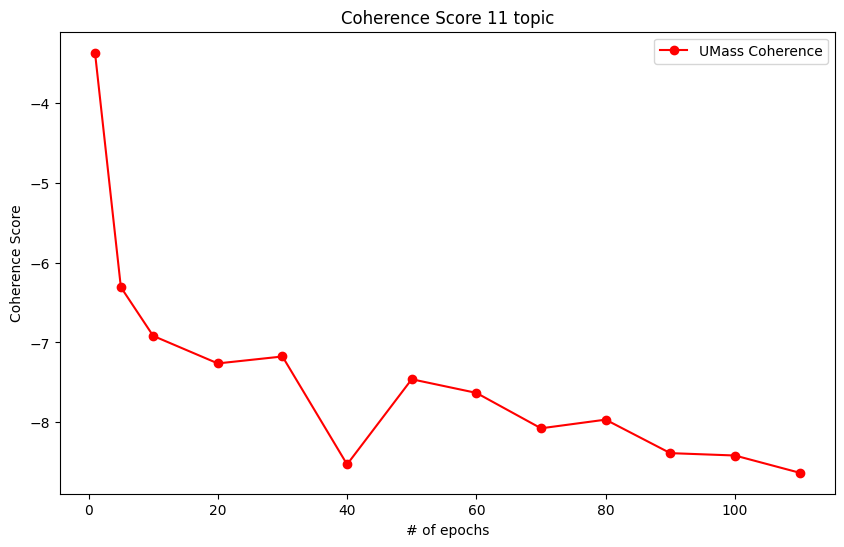

In [33]:
#Plot the coherence 
print("11 topic")
print("Coherence score:", coherence_11_umass)
print("coherence cv: ", coherence_11_cv)

print("Massimo valore umass: ", max(coherence_11_umass))
print("max valore cv: ", max(coherence_11_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_11_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 11 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [34]:
#Executing 15 topics with different epochs
coherence_15_umass = []
coherence_15_cv = []
topic = 15
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_15_umass.append(umass)
    coherence_15_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 15 topics and 1 epochs
Execution time: 0.411 min
Coherence umass: -3.470 e Coherence cv: 0.480

----- TOPIC -----
Topic1: "biden", "border", "trump", "president", "american", "rsvp", "state", "joe", "need", "like"
Topic2: "trump", "president", "biden", "people", "american", "republican", "ukraine", "state", "america", "stand"
Topic3: "trump", "right", "biden", "election", "people", "vote", "state", "marco", "voting", "today"
Topic4: "trump", "biden", "president", "republican", "debt", "time", "american", "democrat", "house", "worker"
Topic5: "biden", "state", "american", "today", "infrastructure", "climate", "border", "people", "energy", "president"
Topic6: "writes", "biden", "american", "president", "student", "job", "community", "america", "people", "great"
Topic7: "american", "today", "job", "michigander", "vote", "day", "biden", "year", "woman", "people"
Topic8: "gun", "care", "act", "child", "american", "veteran", "year", "family", "america", "benefit"
Topic9:

15 topic
Coherence score: [-3.4704472446331396, -6.547665804413929, -7.564835140981712, -8.373488248893803, -9.176637353880638, -9.575133838152261, -9.08730496044915, -9.83641354356248, -10.03636040827181, -9.041968091838323, -8.878014155879589, -10.03168433960103, -8.746033953870894]
coherence cv:  [0.4798215134267718, 0.5210209722253445, 0.5256568211527562, 0.5391944330218731, 0.5480279500774422, 0.5687798323468698, 0.5693526840160944, 0.5794090471332081, 0.5858849508960527, 0.5785804187570437, 0.5740762019930615, 0.5864102671798874, 0.5714203178518316]
Massimo valore umass:  -3.4704472446331396
max valore cv:  0.5864102671798874


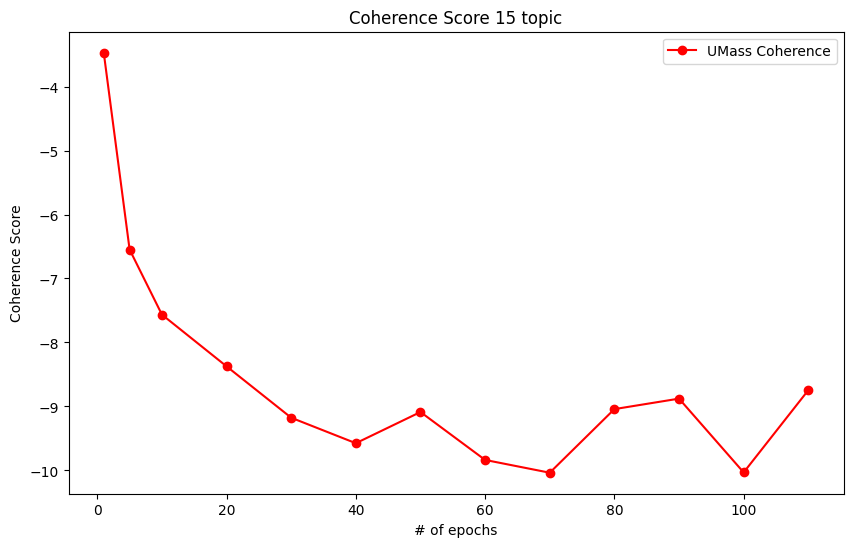

In [35]:
#Plot the coherence 
print("15 topic")
print("Coherence score:", coherence_15_umass)
print("coherence cv: ", coherence_15_cv)

print("Massimo valore umass: ", max(coherence_15_umass))
print("max valore cv: ", max(coherence_15_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_15_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 15 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()


In [36]:
#Executing 19 topics with different epochs
coherence_19_umass = []
coherence_19_cv = []
topic = 19
epochs = [1, 5, 10, 20, 30 ,40 ,50 ,60 ,70 ,80 ,90, 100, 110]
for e in epochs:
    print(f"\n\nExecuting LDA with {topic} topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(topic, tfidf_corpus, dictionary, e)
    coherence_19_umass.append(umass)
    coherence_19_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(topic, model)



Executing LDA with 19 topics and 1 epochs
Execution time: 0.258 min
Coherence umass: -4.076 e Coherence cv: 0.435

----- TOPIC -----
Topic1: "job", "biden", "economy", "american", "created", "year", "president", "million", "people", "work"
Topic2: "thank", "people", "trump", "state", "time", "year", "today", "american", "community", "minnesota"
Topic3: "mccarthy", "kevin", "biden", "gun", "colorado", "american", "house", "older", "people", "year"
Topic4: "trump", "biden", "republican", "toss", "run", "president", "charge", "lean", "democrat", "miami"
Topic5: "american", "biden", "border", "tuberville", "state", "people", "child", "president", "democrat", "time"
Topic6: "insulin", "cost", "senior", "president", "month", "biden", "american", "year", "today", "massachusetts"
Topic7: "right", "gun", "woman", "fight", "today", "community", "violence", "state", "act", "american"
Topic8: "infrastructure", "internet", "speed", "debt", "day", "president", "biden", "republican", "house", "amer

19 topic
Coherence score: [-4.075680493199955, -6.989001948053544, -7.7588145643920425, -8.639618195534707, -9.098349197235162, -8.757348935175811, -8.88066383016376, -9.16349500551578, -9.033521741363572, -8.91061040859163, -9.049559234165832, -8.85512444500582, -8.98700020215609]
coherence cv:  [0.43462452297941306, 0.5309199330326194, 0.5627105051321657, 0.5798253971120838, 0.5524416953922551, 0.5742653190440015, 0.5845331013670154, 0.5752412195473516, 0.5668528883400805, 0.5630668646458536, 0.5715040124440923, 0.5676840371854994, 0.5799557043770388]
Massimo valore umass:  -4.075680493199955
max valore cv:  0.5845331013670154


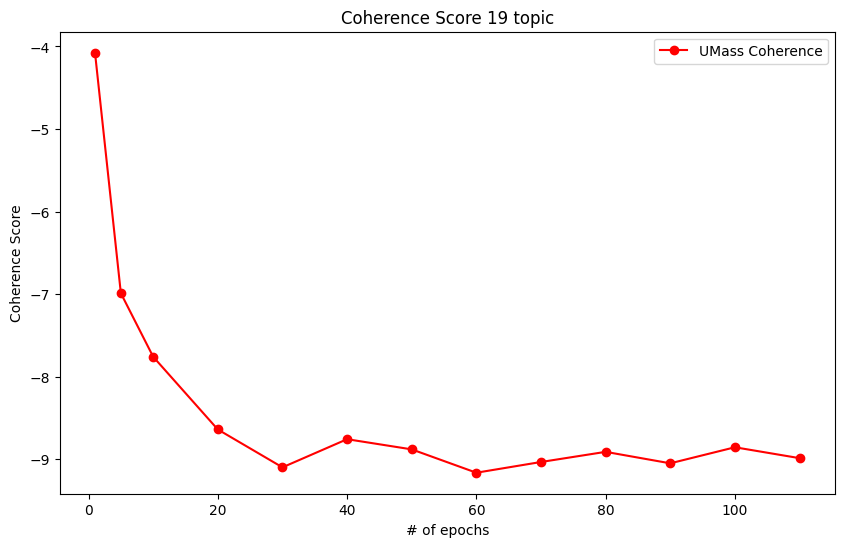

In [37]:
#Plot the coherence 
print("19 topic")
print("Coherence score:", coherence_19_umass)
print("coherence cv: ", coherence_19_cv)

print("Massimo valore umass: ", max(coherence_19_umass))
print("max valore cv: ", max(coherence_19_cv))
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_19_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 19 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()
